In [2]:
import os  ##-> for directory and num_workers
from torch.utils.data import DataLoader ##-> For MNIST Dataset
from torchvision import datasets, transforms ##-> For MNIST Dataset
import matplotlib.pyplot as plt ##-> for plotting loss curves
import numpy as np  ## -> Math
from tqdm import tqdm ## -> For Progressbar
from sklearn.metrics import accuracy_score ##-> accuracy

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        ]),
}

train_data = datasets.MNIST(
    train = True,
    root = 'data/',
    download = True,
    transform = data_transforms['train'],
    target_transform=None,
)

test_data = datasets.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=data_transforms['test'],
    target_transform=None,
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 17643456.46it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 467638.58it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4373915.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2903158.91it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)

In [5]:
class_names = train_data.classes
image , label = train_data[6969]
image.shape , label

(torch.Size([1, 28, 28]), 9)

In [6]:
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

Text(0.5, 1.0, '9 - nine : 9')

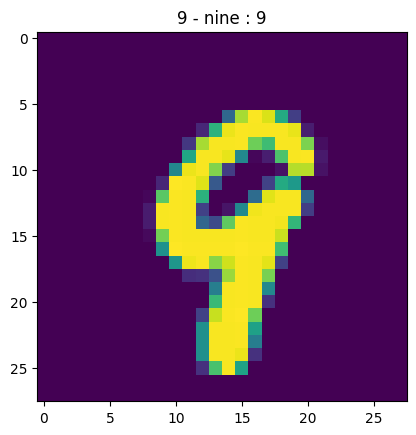

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[label]} : {label}')

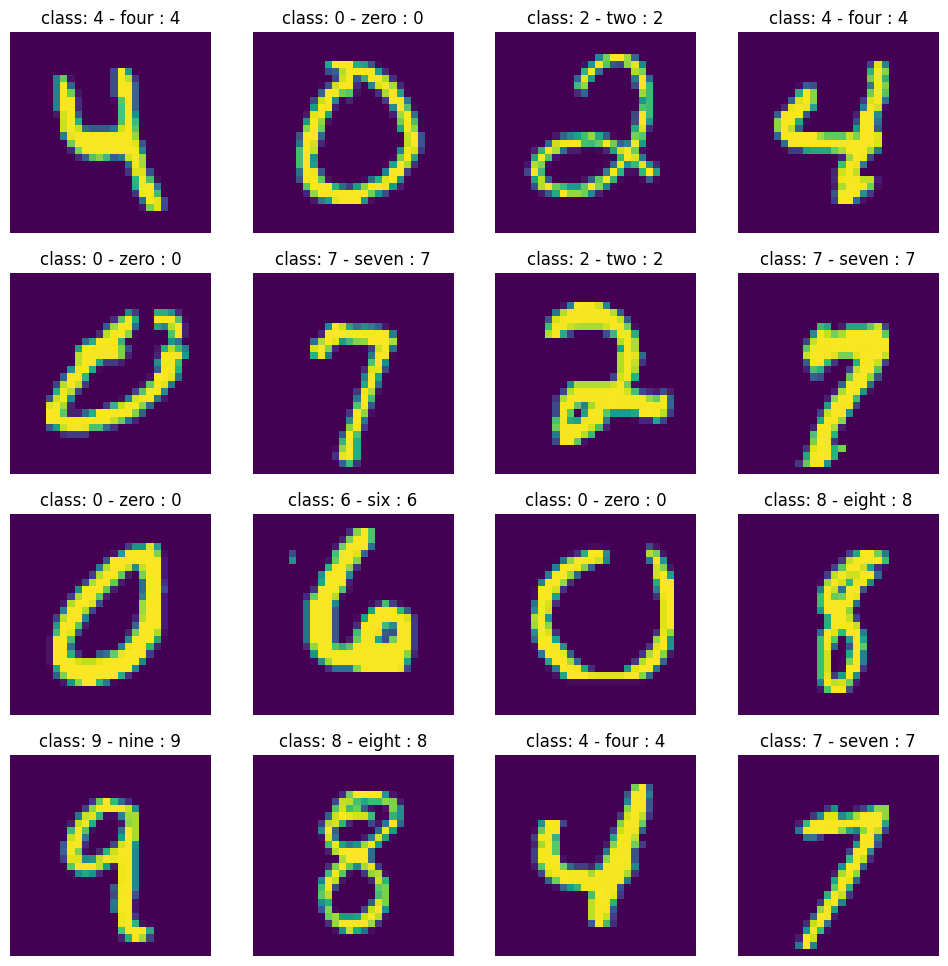

In [9]:
import random
import torch
import matplotlib.pyplot as plt

def plot_random_images(dataset:torch.utils.data.dataset.Dataset ,
                          class_names : list[str] = None,
                          n : int = 3,
                          seed : int = None)->None:
    if seed:
        random.seed(seed)

    fig = plt.figure(figsize=(12, 12))
    for i in range(1,n*n+1):
        random_idx = torch.randint(0 , len(dataset), size = [1]).item()
        image, target = dataset[random_idx]
        fig.add_subplot(n,n,i)
        plt.imshow(image.permute(1,2,0))
        plt.axis(False);
        if class_names:
            title = f"class: {class_names[target]} : {target}"
        else:
            title = None
        plt.title(title)

plot_random_images(dataset = test_data, n = 4 , class_names = class_names )

In [10]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

In [11]:
len(train_dataloader) , len(test_dataloader)

(938, 157)

In [21]:
class SimpleMLP:
    def __init__(self, layer_sizes, learning_rate=0.1):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights, self.biases = self._initialize_weights()

    def _initialize_weights(self):
        np.random.seed(0)
        weights = []
        biases = []
        for i in range(len(self.layer_sizes) - 1):
            weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * 0.01)
            biases.append(np.zeros((1, self.layer_sizes[i + 1])))
        return weights, biases

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        activations = [X]
        input = X
        for w, b in zip(self.weights, self.biases):
            output = self.sigmoid(np.dot(input, w) + b)
            activations.append(output)
            input = output
        return activations

    def backward(self, X, y, activations):
        deltas = [None] * len(self.weights)
        error = y - activations[-1]
        deltas[-1] = error * self.sigmoid_derivative(activations[-1])
        
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = deltas[i + 1].dot(self.weights[i + 1].T) * self.sigmoid_derivative(activations[i + 1])

        for i in range(len(self.weights)):
            self.weights[i] += activations[i].T.dot(deltas[i]) * self.learning_rate
            self.biases[i] += np.sum(deltas[i], axis=0, keepdims=True) * self.learning_rate

    def compute_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def compute_accuracy(self, predictions, labels):
        return np.mean(predictions == labels) * 100

    def train(self, train_loader, test_loader, epochs=10):
        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            train_loss, test_loss = 0, 0
            correct_train, total_train = 0, 0
            correct_test, total_test = 0, 0

            # Training
            for X, y in train_loader:
                X = X.view(-1, 28 * 28).numpy()
                y_onehot = np.eye(10)[y.numpy()]

                activations = self.forward(X)
                self.backward(X, y_onehot, activations)

                loss = self.compute_loss(y_onehot, activations[-1])
                train_loss += loss

                predictions = np.argmax(activations[-1], axis=1)
                correct_train += (predictions == y.numpy()).sum()
                total_train += y.size(0)

            # Testing
            for X, y in test_loader:
                X = X.view(-1, 28 * 28).numpy()
                y_onehot = np.eye(10)[y.numpy()]

                activations = self.forward(X)
                loss = self.compute_loss(y_onehot, activations[-1])
                test_loss += loss

                predictions = np.argmax(activations[-1], axis=1)
                correct_test += (predictions == y.numpy()).sum()
                total_test += y.size(0)

            # Average losses and accuracies
            train_loss /= len(train_loader)
            test_loss /= len(test_loader)
            train_accuracy = correct_train / total_train * 100
            test_accuracy = correct_test / total_test * 100

            # Store losses and accuracies
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.7f}, Test Loss: {test_loss:.7f}, "
                  f"Train Acc: {train_accuracy:.7f}%, Test Acc: {test_accuracy:.7f}%")

        return train_losses, test_losses, train_accuracies, test_accuracies

    def plot_metrics(self, train_losses, test_losses, train_accuracies, test_accuracies):
        epochs = range(1, len(train_losses) + 1)

        # Plotting Loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train vs Test Loss')
        plt.legend()

        # Plotting Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, test_accuracies, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Train vs Test Accuracy')
        plt.legend()

        plt.show()

    def predict(self, data_loader):
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for X, y in data_loader:
                X = X.view(-1, 28 * 28).numpy()  # Flatten and convert to numpy for compatibility
                activations = self.forward(X)
                predictions = np.argmax(activations[-1], axis=1)
                
                all_predictions.extend(predictions)
                all_labels.extend(y.numpy())

        return np.array(all_predictions), np.array(all_labels)

In [22]:
layer_sizes = [784, 64, 10]  # Input layer, hidden layer with 64 neurons, output layer with 10 neurons
mlp = SimpleMLP(layer_sizes, learning_rate=0.01)
train_losses, test_losses, train_accuracies, test_accuracies = mlp.train(train_dataloader, test_dataloader, epochs=20)

Training Epochs:   5%|▌         | 1/20 [00:17<05:27, 17.25s/it]

Epoch 1/20, Train Loss: 0.0666954, Test Loss: 0.0335650, Train Acc: 47.1516667%, Test Acc: 84.6100000%


Training Epochs:  10%|█         | 2/20 [00:33<05:00, 16.67s/it]

Epoch 2/20, Train Loss: 0.0249919, Test Loss: 0.0188373, Train Acc: 87.5816667%, Test Acc: 89.9800000%


Training Epochs:  15%|█▌        | 3/20 [00:50<04:46, 16.85s/it]

Epoch 3/20, Train Loss: 0.0177874, Test Loss: 0.0153512, Train Acc: 90.2983333%, Test Acc: 91.4700000%


Training Epochs:  20%|██        | 4/20 [01:06<04:23, 16.48s/it]

Epoch 4/20, Train Loss: 0.0152391, Test Loss: 0.0136360, Train Acc: 91.4216667%, Test Acc: 92.4600000%


Training Epochs:  25%|██▌       | 5/20 [01:24<04:15, 17.01s/it]

Epoch 5/20, Train Loss: 0.0137007, Test Loss: 0.0125852, Train Acc: 92.2566667%, Test Acc: 92.9000000%


Training Epochs:  30%|███       | 6/20 [01:42<04:02, 17.29s/it]

Epoch 6/20, Train Loss: 0.0125854, Test Loss: 0.0117009, Train Acc: 92.8583333%, Test Acc: 93.4500000%


Training Epochs:  35%|███▌      | 7/20 [01:57<03:34, 16.54s/it]

Epoch 7/20, Train Loss: 0.0116987, Test Loss: 0.0109700, Train Acc: 93.3933333%, Test Acc: 93.7200000%


Training Epochs:  40%|████      | 8/20 [02:15<03:26, 17.21s/it]

Epoch 8/20, Train Loss: 0.0109770, Test Loss: 0.0103794, Train Acc: 93.7666667%, Test Acc: 93.9000000%


Training Epochs:  45%|████▌     | 9/20 [02:32<03:08, 17.14s/it]

Epoch 9/20, Train Loss: 0.0103939, Test Loss: 0.0099053, Train Acc: 94.1633333%, Test Acc: 94.2100000%


Training Epochs:  50%|█████     | 10/20 [02:50<02:51, 17.19s/it]

Epoch 10/20, Train Loss: 0.0098817, Test Loss: 0.0095409, Train Acc: 94.4183333%, Test Acc: 94.4700000%


Training Epochs:  55%|█████▌    | 11/20 [03:08<02:36, 17.38s/it]

Epoch 11/20, Train Loss: 0.0094347, Test Loss: 0.0092855, Train Acc: 94.7083333%, Test Acc: 94.5400000%


Training Epochs:  60%|██████    | 12/20 [03:27<02:23, 17.88s/it]

Epoch 12/20, Train Loss: 0.0090470, Test Loss: 0.0089651, Train Acc: 94.9233333%, Test Acc: 94.8500000%


Training Epochs:  65%|██████▌   | 13/20 [03:42<01:59, 17.05s/it]

Epoch 13/20, Train Loss: 0.0087063, Test Loss: 0.0086280, Train Acc: 95.0916667%, Test Acc: 95.0400000%


Training Epochs:  70%|███████   | 14/20 [03:59<01:43, 17.28s/it]

Epoch 14/20, Train Loss: 0.0083968, Test Loss: 0.0083922, Train Acc: 95.2933333%, Test Acc: 95.0900000%


Training Epochs:  75%|███████▌  | 15/20 [04:16<01:25, 17.13s/it]

Epoch 15/20, Train Loss: 0.0081030, Test Loss: 0.0081714, Train Acc: 95.5066667%, Test Acc: 95.4000000%


Training Epochs:  80%|████████  | 16/20 [04:34<01:08, 17.17s/it]

Epoch 16/20, Train Loss: 0.0078436, Test Loss: 0.0080250, Train Acc: 95.6683333%, Test Acc: 95.4300000%


Training Epochs:  85%|████████▌ | 17/20 [04:48<00:49, 16.42s/it]

Epoch 17/20, Train Loss: 0.0076053, Test Loss: 0.0077785, Train Acc: 95.7800000%, Test Acc: 95.6500000%


Training Epochs:  90%|█████████ | 18/20 [05:04<00:32, 16.09s/it]

Epoch 18/20, Train Loss: 0.0073842, Test Loss: 0.0075478, Train Acc: 95.9283333%, Test Acc: 95.7000000%


Training Epochs:  95%|█████████▌| 19/20 [05:20<00:16, 16.07s/it]

Epoch 19/20, Train Loss: 0.0071712, Test Loss: 0.0074480, Train Acc: 96.0250000%, Test Acc: 95.7700000%


Training Epochs: 100%|██████████| 20/20 [05:38<00:00, 16.90s/it]

Epoch 20/20, Train Loss: 0.0069862, Test Loss: 0.0072142, Train Acc: 96.1716667%, Test Acc: 95.9000000%


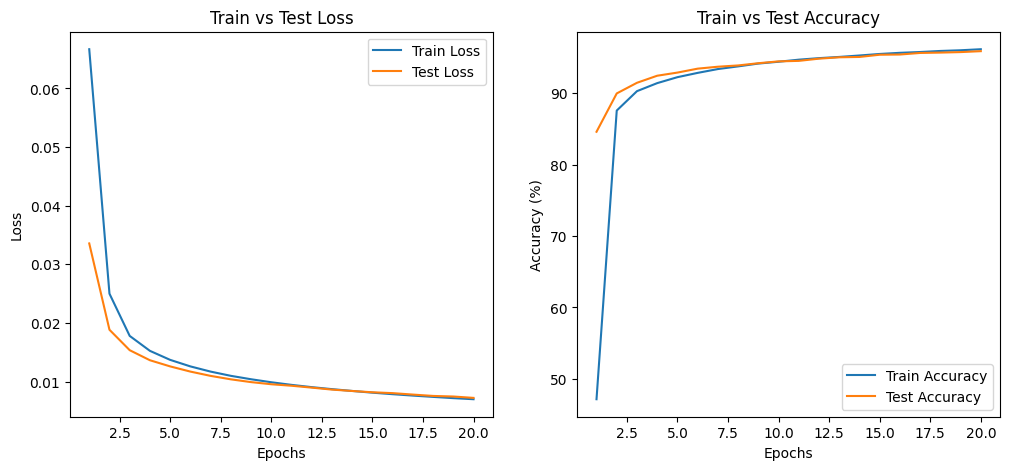

In [23]:
mlp.plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

In [25]:
train_preds , train_targets = mlp.predict(train_dataloader)
test_preds , test_targets = mlp.predict(test_dataloader)

print(f'Training Accuarcy : {accuracy_score(train_targets, train_preds)*100}%')
print(f'Test Accuarcy : {accuracy_score(test_targets, test_preds)*100}%')

Training Accuarcy : 96.31333333333333%
Test Accuarcy : 95.89999999999999%


In [58]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

In [59]:
def make_predictions(model: SimpleMLP, data: list):
    pred_probs = []

    # Evaluate mode (no model.eval() as it's a custom numpy-based model)
    for sample in data:
        sample = sample.view(-1, 28 * 28).numpy()  # Flatten and convert to numpy array for compatibility
        
        # Forward pass
        activations = model.forward(sample)
        
        # Compute softmax on output layer manually
        pred_prob = np.exp(activations[-1]) / np.sum(np.exp(activations[-1]), axis=1, keepdims=True)
        pred_probs.append(pred_prob)

    return np.vstack(pred_probs)  # Stack the predictions into a single numpy array

pred_probs= make_predictions(model=mlp,
                             data=test_samples)

pred_classes = pred_probs.argmax(1)
pred_classes

array([9, 5, 0, 7, 9, 4, 5, 7, 7, 6, 8, 3, 8, 9, 7, 6])

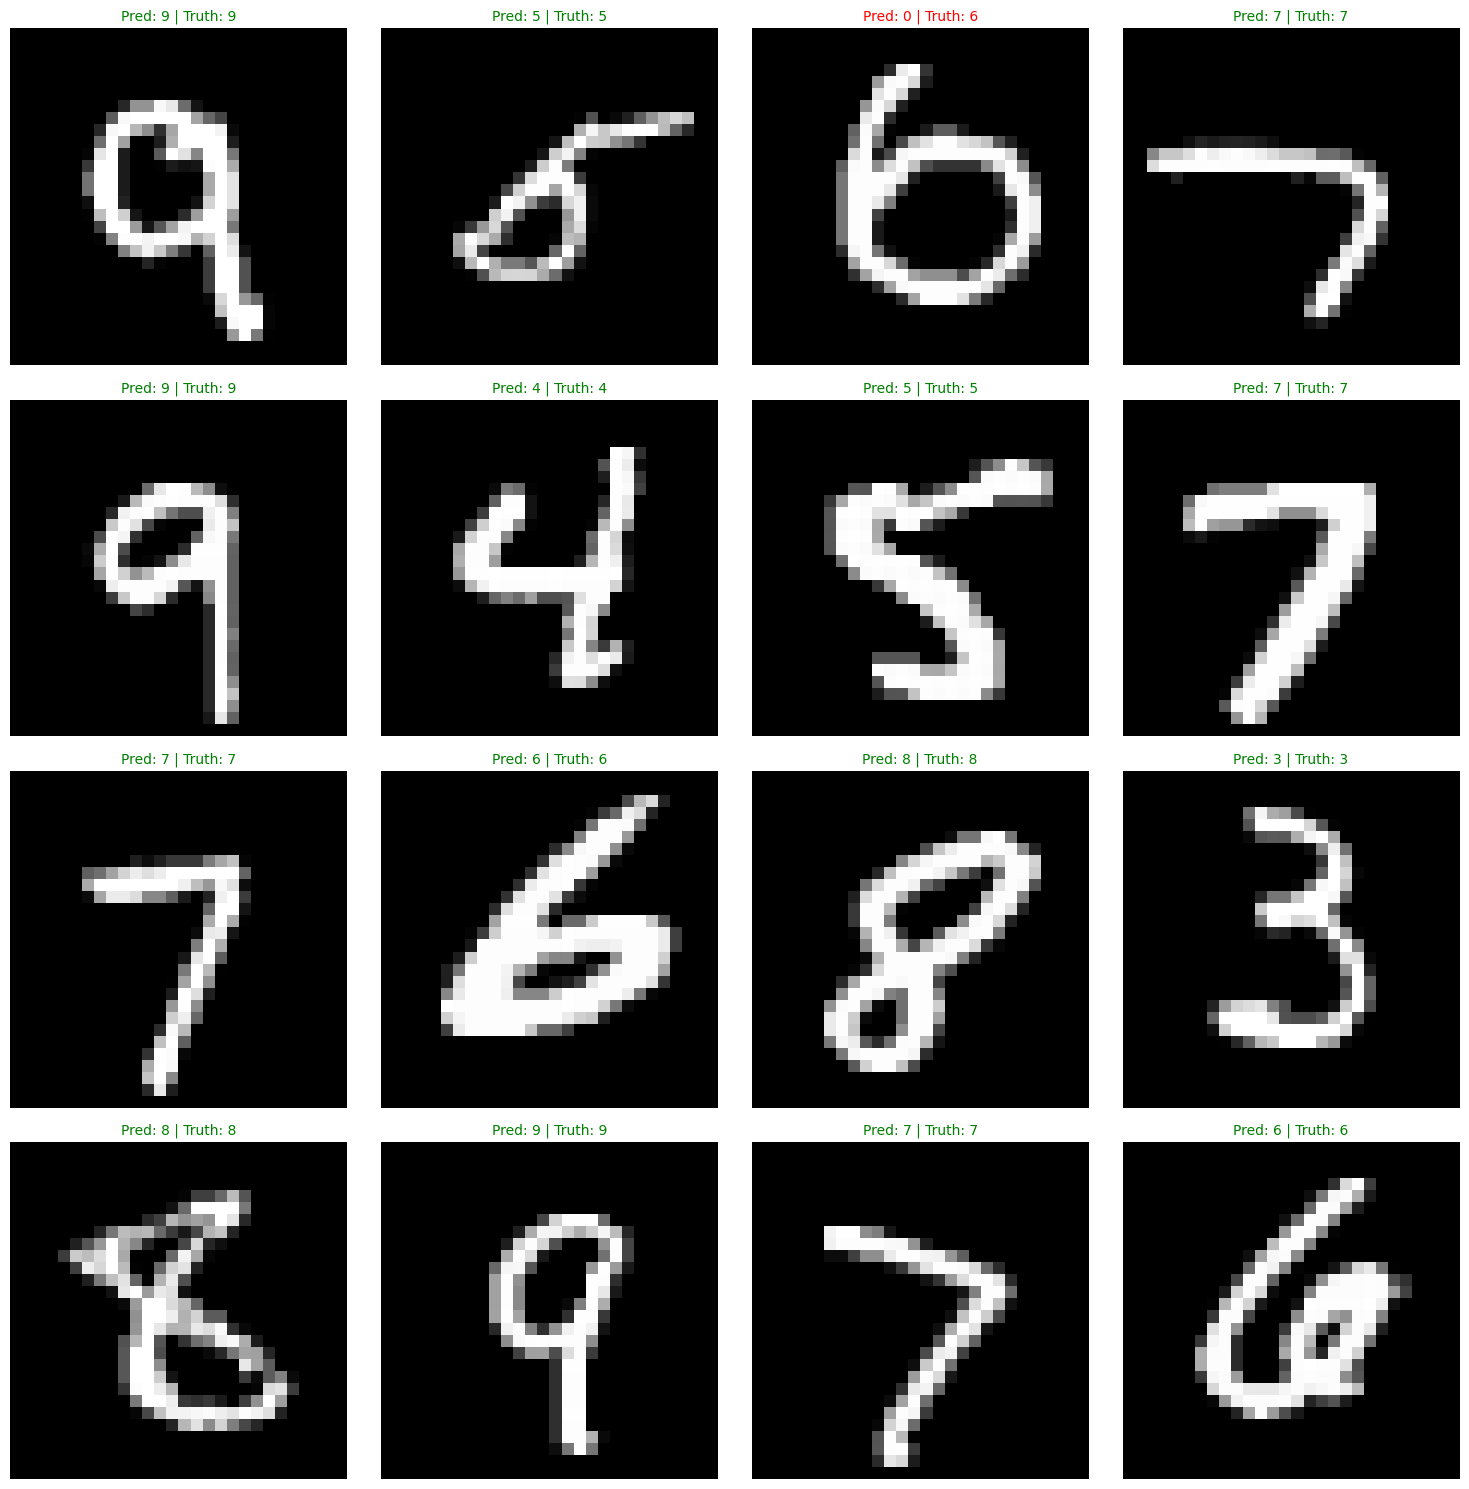

In [60]:
def plot_predicted_images(samples: list,
                          test_targets: np.ndarray,
                          test_preds: np.ndarray, 
                          class_names: list,
                          rows: int = 4,
                          cols: int = 4):
    
    # Convert predictions and targets to numpy arrays if they're not already
    test_targets = np.array(test_targets).astype(int)
    test_preds = np.array(test_preds).astype(int)
    
    plt.figure(figsize=(15, 15))
    for i, sample in enumerate(samples[:rows * cols]):  # Plot only as many as rows*cols
        plt.subplot(rows, cols, i + 1)
        
        # Reshape each sample to 28x28 for visualization
        sample_image = sample.reshape(28, 28)
        plt.imshow(sample_image, cmap="gray")
        
        # Use .item() to extract single integer value from array or tensor
        pred_label = class_names[test_preds[i].item()]  
        truth_label = class_names[test_targets[i].item()]

        # Set title with color indicating correct or incorrect prediction
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"
        title_color = "g" if pred_label == truth_label else "r"
        plt.title(title_text, fontsize=10, color=title_color)
        
        plt.axis("off")  # Hide axis

    plt.tight_layout()
    plt.show()

# Usage example:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_predicted_images(test_samples, test_labels, pred_classes, class_names)